## nsdmd generative model development

This model is used to do model comparison on four Dark Matter density profiles. The model compared 4 density files: NFW profile, Isothermal profile, Einasto profile and Generalized DM profile by comparing their log evidence in fitting rotational velocity cruve. We use the model density file with unknown parametes to calculate the enclosing mass and the corresponding rotational velocity. Then we use package nestle to find the best parameters fitting for the function.

### Model
Model 

$ M $ = The rotational curve calculated with the existence of dark matter and the dark matter density is given by the density profile. We have four dark matter density files and give us 4 models to compare. 

The posterior distribution is calculated as, $ p(M|D,I) = \frac{p(M|I) p(D|M, I)}{p(D|I)} $



### The four Dark Matter density profiles models: 

Note that

r: galactocentric radius

$ \rho( r ) $ : Dark Matter Density as a function of galactocentric radius


### (1) NFW profile :

 $ \rho \left( r \right) \propto \frac{1}{{\left( r/a \right)}{\left[ 1~+~{{\left( r/a \right)}} \right]}^{2}} $


### (2) Isothermal profile:

  $  \rho \left( r \right) \propto \frac{1}{{\left[ 1~+~{{\left( r/a \right)}^{2}} \right]}} $


### (3) Einasto profile :

 $ \rho \left( r \right) \propto \exp^{- A r ^\alpha} $


### (4) Generalized DM profile :

 $ \rho \left( r \right) \propto    \frac{1}{{\left( r/a \right)}^{\gamma}{\left[ 1~+~{{\left( r/a \right)}^{\alpha}} \right]}^{ \frac{(\beta - \gamma)}{\alpha}}} $



### We can calcuate rotational curve from Dark Matter density profiles, by assuming dark matter distribution is spherically symmetric

$ \frac{GMm}{4 \pi  R^2} = \frac {m v^2}{R}$  where $M=\int_{R_o}^{R} \rho (r) 4 \pi  R^2 dr$

$v_{calculated} = \sqrt { \frac{ G   \int_{R_o}^{R} \rho (r) 4 \pi  r^2 dr} {4 \pi  r}  }   $

$ v_{calculated}  \left( r \right) \propto    \sqrt {  \int_{0}^{R} \rho (r) r dr  }  $


### Imports

In [1]:
  #  !!!! pip install nestle  (from terminal)
    
# !conda install -y -c conda-forge nestle (somehow couldn't find nestle)

In [2]:
import numpy as np
import nestle
import math

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import corner

from scipy.integrate import quad

from nsdmd import model 
from nsdmd import io

import pandas as pd

### Loading the and visualizing the data

We are going to define the data for two references:

Reference 1: Bhattacharjee et. al.

Reference 2: Sofue 

The data will be used in this project is the measured rotational speed of the interstellar medium in our local galaxy, as shown in the following figure. 

In [ ]:
data_x_ref1,data_xerr_ref1,data_y_ref1,data_yerr_ref1 =io.load_data('dataref1.txt')
data_x_ref2,data_xerr_ref2,data_y_ref2,data_yerr_ref2 =io.load_data('dataref2.txt')

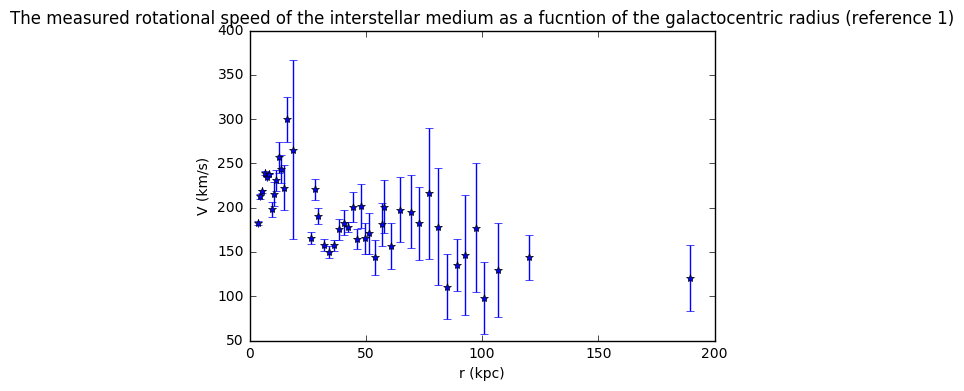

In [4]:
plt.figure()
plt.errorbar(data_x_ref1,data_y_ref1,xerr=data_xerr_ref1,yerr=data_yerr_ref1,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 1)")
plt.show()

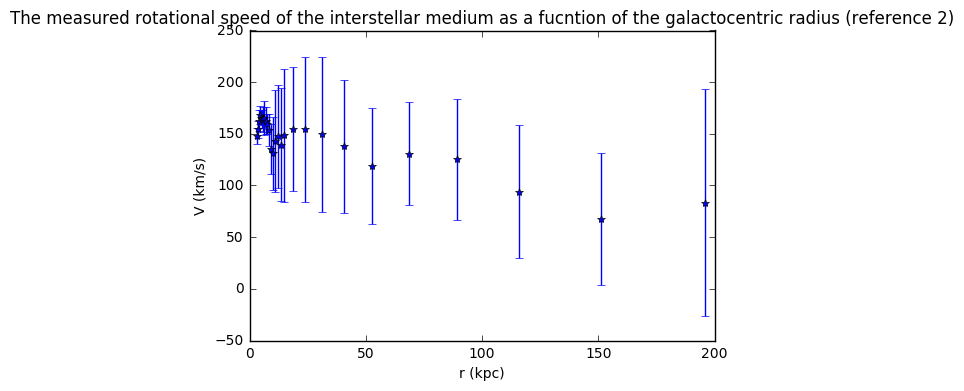

In [5]:
plt.figure()
plt.errorbar(data_x_ref2,data_y_ref2,xerr=data_xerr_ref2,yerr=data_yerr_ref2,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 2)")
plt.show()

### The log likelihood is meant to capture how well a model is able to reproduce the data that it is meant to simulate.

$log p(D|M, I) = constant* \prod_{i}^{} log(\sigma_i)  \sum_{i}{}(\frac{(v_{icalculated} - v_{imeasured})^2}{2 \sigma_i^2}) $

$constant* \prod_{i}^{} log(\sigma_i) $, this part doesn't matter much since they are the same for all. 

$log p(D|M, I) =  \sum_{i}{}(\frac{(v_{icalculated} - v_{imeasured})^2}{2 \sigma_i^2}) $

## Defining the model we use to describe the data

### NFW

We are going to calculate the mass between 0 and each data point by integrating the NFW distribution. However, the mass defined here does not include the normalization constant rho0 (kg/kpc^3).

mass = 4.*np.pi*(a**3)*(np.log((a+x)/a)-x/(a+x))

To calculate the rotation velocity: vrot = theta[1]*sqrt(mass/x)
    
The rotation velocity is equal to sqrt(G*rho0)*sqrt((M/rho0)/x) where M is the mass enclosed, rho0 is the normalization constant of the mass distribution, and x is the distance at which we calculate vrot. When we determine theta[1], we determine sqrt(G*rho0). Since theta[1] = sqrt(G*rho0) we can now determine rho0: rho0 = theta[1]^2/G. The units on the right-hand side are: (3.24E-17 1/s)^2/(m^3/(kg s^2)) = (3.24E-17)^2 kg/(m^3). To convert from kg/m^3 to kg/kpc^3, we multiply by (3.086E19)^3. The normalization constant rho0 is thus (theta1[1]^2)/6.67E-11 * ((3.24E-17)^2 * (3.086E19)^3 kg/(kpc)^3 = (theta1[1]^2)*4.625E35 kg/(kpc)^3 = 2.312E5 Msun/(kpc)^3.
    
The units of a are kpc, thus the units of the "mass" calculated here are thus kpc^3. The units of sqrt(mass/x) are kpc. The units of vrot are km/s. The units of theta[1] are thus (km/s)/kpc = (10^3 m)/s/(3.086E19 m) = 3.24E-17 1/s.

#### Log Likelihood of NFW

Again, to calculate the mass between 0 and data_x by integrating the NFW distribution.
a = theta[0]
mass = 4.*np.pi*(a**3)*(np.log((a+data_x_ref1)/a)-data_x_ref1/(a+data_x_ref1))
        
vrot = theta[1]*np.sqrt(mass/data_x_ref1) 
        
chisq = np.sum(((data_y_ref1 - vrot) / data_yerr_ref1)**2)

Result = -chisq/2

#### Prior for NFW model

It is a transformation from a space where variables are independently and uniformly distributed between 0 and 1 to the parameter space of interest. 

theta[0] in the range of [0,10] and theta[1] in the range of [0,300]

Result = np.array([20, 500]) * theta

In [ ]:
result_NFW_ref1 = nestle.sample(loglike_NFW_ref1, prior_transform_NFW, 2)
result_NFW_ref2 = nestle.sample(loglike_NFW_ref2, prior_transform_NFW, 2)

p_NFW_ref1, cov_NFW_ref1 = nestle.mean_and_cov(result_NFW_ref1.samples, result_NFW_ref1.weights)
p_NFW_ref2, cov_NFW_ref2 = nestle.mean_and_cov(result_NFW_ref2.samples, result_NFW_ref2.weights)

# Start with printing the results of the fit based on the data from reference 1
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_NFW_ref1[0], np.sqrt(cov_NFW_ref1[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f} km/s/kpc".format(p_NFW_ref1[1], np.sqrt(cov_NFW_ref1[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_NFW_ref1[1], 
                                                                                      2.312E5*np.sqrt(cov_NFW_ref1[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_NFW(p_NFW_ref1, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_NFW(p_NFW_ref1, 8)))

plt.figure()
plt.errorbar(data_x_ref1,data_y_ref1,xerr=data_xerr,yerr=data_yerr_ref1,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 1)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_NFW(p_NFW_ref1, xplot))
plt.show()

fig = corner.corner(result_NFW_ref1.samples, weights=result_NFW_ref1.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()


# Continue with printing the results of the fit based on the data from reference 2
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_NFW_ref2[0], np.sqrt(cov_NFW_ref2[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f} km/s/kpc".format(p_NFW_ref2[1], np.sqrt(cov_NFW_ref2[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_NFW_ref2[1], 
                                                                                      2.312E5*np.sqrt(cov_NFW_ref2[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_NFW(p_NFW_ref2, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_NFW(p_NFW_ref2, 8)))

plt.figure()
plt.errorbar(data_x_ref2,data_y_ref2,xerr=data_xerr,yerr=data_yerr_ref2,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 2)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_NFW(p_NFW_ref2, xplot))
plt.show()

fig = corner.corner(result_NFW_ref2.samples, weights=result_NFW_ref2.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()

### Isothermal

We are going to calculate the mass between 0 and each data point by integrating the NFW distribution. However, the mass defined here does not include the normalization constant rho0 (kg/kpc^3).

mass = 4.*np.pi*(a**3)*(x/a - np.arctan(x/a))

To calculate the rotation velocity: vrot = theta[1]*sqrt(mass/x)
    
The rotation velocity is equal to sqrt(G*rho0)*sqrt((M/rho0)/x) where M is the mass enclosed, rho0 is the normalization constant of the mass distribution, and x is the distance at which we calculate vrot. When we determine theta[1], we determine sqrt(G*rho0). Since theta[1] = sqrt(G*rho0) we can now determine rho0: rho0 = theta[1]^2/G. The units on the right-hand side are: (3.24E-17 1/s)^2/(m^3/(kg s^2)) = (3.24E-17)^2 kg/(m^3). To convert from kg/m^3 to kg/kpc^3, we multiply by (3.086E19)^3. The normalization constant rho0 is thus (theta1[1]^2)/6.67E-11 * ((3.24E-17)^2 * (3.086E19)^3 kg/(kpc)^3 = (theta1[1]^2)*4.625E35 kg/(kpc)^3 = 2.312E5 Msun/(kpc)^3.
    
The units of a are kpc, thus the units of the "mass" calculated here are thus kpc^3. The units of sqrt(mass/x) are kpc. The units of vrot are km/s. The units of theta[1] are thus (km/s)/kpc = (10^3 m)/s/(3.086E19 m) = 3.24E-17 1/s.

#### Log Likelihood of Isothermal

Again, to calculate the mass between 0 and data points by integrating the Isothermal distribution.
a = theta[0]
mass = 4.*np.pi*(a**3)*(data_x_ref2/a - np.arctan(data_x_ref2/a))
        
vrot = theta[1]*np.sqrt(mass/data_x_ref1) 
        
chisq = np.sum(((data_y_ref1 - vrot) / data_yerr_ref1)**2)

Result = -chisq/2

#### Prior for Isothermal model

It is a transformation from a space where variables are independently and uniformly distributed between 0 and 1 to the parameter space of interest. 

theta[0] in the range of [0,10] and theta[1] in the range of [0,300]

Result = np.array([5, 1000]) * theta

In [ ]:
result_ISO_ref1 = nestle.sample(loglike_ISO_ref1, prior_transform_ISO, 2)
result_ISO_ref2 = nestle.sample(loglike_ISO_ref2, prior_transform_ISO, 2)

p_ISO_ref1, cov_ISO_ref1 = nestle.mean_and_cov(result_ISO_ref1.samples, result_ISO_ref1.weights)
p_ISO_ref2, cov_ISO_ref2 = nestle.mean_and_cov(result_ISO_ref2.samples, result_ISO_ref2.weights)

# Start with printing the results of the fit based on the data from reference 1
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_ISO_ref1[0], np.sqrt(cov_ISO_ref1[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f} km/s/kpc".format(p_ISO_ref1[1], np.sqrt(cov_ISO_ref1[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_ISO_ref1[1], 
                                                                                      2.312E5*np.sqrt(cov_ISO_ref1[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_ISO(p_ISO_ref1, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_ISO(p_ISO_ref1, 8)))

plt.figure()
plt.errorbar(data_x_ref1,data_y_ref1,xerr=data_xerr,yerr=data_yerr_ref1,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 1)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_ISO(p_ISO_ref1, xplot))
plt.show()

fig = corner.corner(result_ISO_ref1.samples, weights=result_ISO_ref1.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()


# Continue with printing the results of the fit based on the data from reference 2
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_ISO_ref2[0], np.sqrt(cov_ISO_ref2[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f} km/s/kpc".format(p_ISO_ref2[1], np.sqrt(cov_ISO_ref2[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_ISO_ref2[1], 
                                                                                      2.312E5*np.sqrt(cov_ISO_ref2[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_ISO(p_ISO_ref2, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_ISO(p_ISO_ref2, 8)))

plt.figure()
plt.errorbar(data_x_ref2,data_y_ref2,xerr=data_xerr,yerr=data_yerr_ref2,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 2)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_ISO(p_ISO_ref2, xplot))
plt.show()

fig = corner.corner(result_ISO_ref2.samples, weights=result_ISO_ref2.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()

### Einasto 

This time we start with defining the Einasto density function. The units are kpc.

rho = np.exp(-2.*n*(x/a)**(1./n) - 1.)

Then we calculate the integrand for mass integration: rho*x**2

mass = 4.*np.pi*integral(rho*x**2)

vrot = theta[2]*np.sqrt(mass/x) 

The rotation velocity is equal to sqrt(Grho0)sqrt((M/rho0)/x) where M is the mass enclosed, rho0 is the normalization constant of the mass distribution, and x is the distance at which we calculate vrot. When we determine theta[1], we determine sqrt(Grho0). Since theta[1] = sqrt(Grho0) we can now determine rho0: rho0 = theta[1]^2/G. The units on the right-hand side are: (3.24E-17 1/s)^2/(m^3/(kg s^2)) = (3.24E-17)^2 kg/(m^3). To convert from kg/m^3 to kg/kpc^3, we multiply by (3.086E19)^3. The normalization constant rho0 is thus (theta1[1]^2)/6.67E-11 ((3.24E-17)^2 (3.086E19)^3 kg/(kpc)^3 = (theta1[1]^2)*4.625E35 kg/(kpc)^3 = 2.312E5 Msun/(kpc)^3.

The units of a are kpc, thus the units of the "mass" calculated here are thus kpc^3. The units of sqrt(mass/x) are kpc. The units of vrot are km/s. The units of theta[1] are thus (km/s)/kpc = (10^3 m)/s/(3.086E19 m) = 3.24E-17 1/s.

#### Log Likelihood of Einasto

Again, to calculate the mass between 0 and data points by integrating the Isothermal distribution. 

mass = 4.*np.pi*integral(rho*x**2)

vrot = theta[2]*np.sqrt(mass/data_x_ref1) 

chisq = np.sum(((data_y_ref1 - vrot) / data_yerr_ref1)**2)

Result = -chisq/2

#### Prior for Einasto model

It is a transformation from a space where variables are independently and uniformly distributed between 0 and 1 to the parameter space of interest.

theta[0] and theta[1] in the range of [0,10] and theta[1] in the range of [0,500]

Result = np.array([10, 10, 500]) * theta

In [ ]:
result_Einasto_ref1 = nestle.sample(loglike_Einasto_ref1, prior_transform_Einasto, 3)
result_Einasto_ref2 = nestle.sample(loglike_Einasto_ref2, prior_transform_Einasto, 3)

p_Einasto_ref1, cov_Einasto_ref1 = nestle.mean_and_cov(result_Einasto_ref1.samples, result_Einasto_ref1.weights)
p_Einasto_ref2, cov_Einasto_ref2 = nestle.mean_and_cov(result_Einasto_ref2.samples, result_Einasto_ref2.weights)

# Start with printing the results of the fit based on the data from reference 1
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_Einasto_ref1[0], np.sqrt(cov_Einasto_ref1[0, 0])))
print("n = {0:5.2f} +/- {1:5.2f}".format(p_Einasto_ref1[1], np.sqrt(cov_Einasto_ref1[1, 1])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f} km/s/kpc".format(p_Einasto_ref1[2], np.sqrt(cov_Einasto_ref1[2, 2])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_Einasto_ref1[2], 
                                                                                      2.312E5*np.sqrt(cov_Einasto_ref1[2, 2])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_Einasto(p_Einasto_ref1, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_Einasto(p_Einasto_ref1, 8)))

plt.figure()
plt.errorbar(data_x_ref1,data_y_ref1,xerr=data_xerr,yerr=data_yerr_ref1,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 1)")
xplot = [5.+5.*i for i in range(40)]
yplot = [model_Einasto(p_Einasto_ref1, xplot[i]) for i in range(40)]
plt.plot(xplot,yplot)
plt.show()

fig = corner.corner(result_Einasto_ref1.samples, weights=result_Einasto_ref1.weights, labels=['a', 'n', 'rho0'],
                    range=[0.99999, 0.99999, 0.99999], bins=30)
plt.show()


# Continue with printing the results of the fit based on the data from reference 2
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_Einasto_ref2[0], np.sqrt(cov_Einasto_ref2[0, 0])))
print("n = {0:5.2f} +/- {1:5.2f}".format(p_Einasto_ref2[1], np.sqrt(cov_Einasto_ref2[1, 1])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f} km/s/kpc".format(p_Einasto_ref2[2], np.sqrt(cov_Einasto_ref2[2, 2])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_Einasto_ref2[2], 
                                                                                      2.312E5*np.sqrt(cov_Einasto_ref2[2, 2])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_Einasto(p_Einasto_ref2, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_Einasto(p_Einasto_ref2, 8)))

plt.figure()
plt.errorbar(data_x_ref2,data_y_ref2,xerr=data_xerr,yerr=data_yerr_ref2,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 2)")
xplot = [5+5*i for i in range(40)]
yplot = [model_Einasto(p_Einasto_ref1, xplot[i]) for i in range(40)]
plt.plot(xplot,yplot)
plt.show()

fig = corner.corner(result_Einasto_ref1.samples, weights=result_Einasto_ref1.weights, labels=['a', 'n', 'rho0'],
                    range=[0.99999, 0.99999, 0.99999], bins=30)

plt.show()

### Generalized model????

## Nestle

Therefore, we calculated the posterior $ p(M|D,I) = \frac{p(M|I) p(D|M, I)}{p(D|I)} $ and compare the posterior by MCMC and/or Nestle to do model comparison. 

By using the Nestle package, it will give us log evidence, numerical (sampling) error on logz, array of sample parameters, array of weights associated with each sampleand result.weights. 